In [6]:
import pandas as pd
pd.set_option('display.max_rows', 200) 
import datetime as dt 
import matplotlib.pyplot as plt 
import pandas_datareader as web 
import math
from statistics import mean
from scipy import stats
import json
import yfinance as yf
import requests
import matplotlib.pyplot as plt 
import openai

In [7]:
# Import functions
from m_udfs import batcher
from m_udfs import robot_analyst

# Import API Keys
from m_config import IEX_API_KEY 
from m_config import OPENAI_API_KEY

In [ ]:
# The robot analyst function - used during developement or to look up stock terms
robot_analyst()

In [9]:
# Determine intital investment ($25000) or user input desired amount
pf_size = input('Initial Investment: $')

try:
    val = float(pf_size)
    print(f'${val}')
except ValueError:
    print('Hint: Use integers\nTry again...')
    pf_size = input('Initial Investment: $')
    
# S&P 500 Fundamental Holdings Data
fund_df = pd.read_csv('20220811_fund_holdings.csv')

fund_df.columns = [x.lower() for x in fund_df.columns] # Pass the function as a list
fund_df.columns = fund_df.columns.str.replace(' ','_')

# Drop worthless columm
fund_df.drop(['unnamed:_0', 'accrual_date'], axis=1, inplace=True)
fund_df[fund_df['asset_class']!='Equity']
fund_df.head() # Check for abc

# Filter out asset_classes
fund_df = fund_df[fund_df['asset_class'] == 'Equity'] # Return rows where the asset_class is 'Equity'
fund_df.sort_values('ticker', inplace=True, ascending=True, ignore_index=True)

# fund_df.shape # Check df length

fund_df.reset_index(drop=True, inplace=True)

# fund_df.head()

fund_df_size = len(fund_df.index)
# print(f'Dataframe Length (Size): {fund_df_size}')

cv_ticks = fund_df.iloc[:,:2]
cv_ticks.sort_values('ticker', inplace=True, ascending=True, ignore_index=True)

# cv_ticks.shape

$25000.0


In [ ]:
# Create a list of lists (Create a batching generator and pass it to an object as a list)
cv_ticks_grps = list(batcher(cv_ticks['ticker'], 100))
cv_tick_strings = [] 

for i in range(0, len(cv_ticks_grps)): 
    cv_tick_strings.append(','.join(cv_ticks_grps[i])) 
    print(cv_tick_strings[i]) 


In [ ]:
cv_tick_strings # Look for 5 groups (batch api calls)

In [45]:
# Determine batch count
len(cv_tick_strings)

6

In [13]:
# Create columns for initial data analysis
cv_cols = ['ticker','latest_price','one-year-price-return', 'shares']
cv_df = pd.DataFrame(columns = cv_cols)

cv_df # Verify columns with (should have an empty data frame)

,ticker,latest_price,one-year-price-return,shares


In [46]:
hqm_df_cols = [
                'ticker',
                'latest_price',
                'shares',
                'two_year_price_return', 
                'two_year_price_return_percentile',
                'one_year_price_return',
                'one_year_price_return_percentile',
                'six_month_price_return',
                'six_month_price_return_percentile',
                'three_month_price_return',
                'three_month_price_return_percentile',
                # 'one-month-price-return',
                # 'one-month-price-return-percentile',
                'hqm_score'
               ]

hqm_df = pd.DataFrame(columns = hqm_df_cols)

hqm_df

,ticker,latest_price,shares,two_year_price_return,two_year_price_return_percentile,one_year_price_return,one_year_price_return_percentile,six_month_price_return,six_month_price_return_percentile,three_month_price_return,three_month_price_return_percentile,hqm_score


In [15]:
# Verify again batch count
len(cv_tick_strings)

6

In [ ]:
for cv_tick in cv_tick_strings: # Prod
# for cv_tick in cv_tick_strings[:1]: # Testing
    iex_b_api = f'https://cloud.iexapis.com/v1/stock/market/batch?symbols={cv_tick}&types=price,stats&token={IEX_API_KEY}'
    data = requests.get(iex_b_api).json()
    
    for cv_t in cv_tick.split(','):
        hqm_df = hqm_df.append(pd.Series(
            
            [
                cv_t, # ticker
                data[cv_t]['price'], # latest_price
                'NA', # shares
                data[cv_t]['stats']['year2ChangePercent'], # two-year-price-return
                'NA', # two-year-price-return-percentile
                data[cv_t]['stats']['year1ChangePercent'], # one-year-price-return
                'NA', # one-year-price-return-percentile
                data[cv_t]['stats']['month6ChangePercent'], # six-month-price-return
                'NA', # six-month-price-return-percentile
                data[cv_t]['stats']['month3ChangePercent'], # three-month-price-return
                'NA', # three-month-price-return_percentile
                # data[cv_t]['stats']['month1ChangePercent'], # one-month-price-return
                # 'NA', # one-month-price-return-percentile
                'NA' # hqm_score
            ],
            index = hqm_df_cols # Add hqm columns here
            ),
            ignore_index=True 
            )
print(len(hqm_df))

In [17]:
# View the dataframe head
hqm_df.head()

,ticker,latest_price,shares,two_year_price_return,two_year_price_return_percentile,one_year_price_return,one_year_price_return_percentile,six_month_price_return,six_month_price_return_percentile,three_month_price_return,three_month_price_return_percentile,hqm_score
0,A,156.96,NA,0.389339,NA,0.038766,NA,0.271782,NA,0.210685,NA,NA
1,AAL,14.50,NA,-0.029451,NA,-0.183099,NA,-0.158933,NA,0.055313,NA,NA
2,AAP,150.00,NA,0.047007,NA,-0.318920,NA,-0.200293,NA,-0.128205,NA,NA
3,AAPL,148.11,NA,0.291803,NA,-0.050000,NA,0.033257,NA,-0.093291,NA,NA
4,ABBV,159.62,NA,0.667882,NA,0.423388,NA,0.080909,NA,0.182575,NA,NA


In [18]:
# View the data frame columns as a list
hqm_df.columns

Index(['ticker', 'latest_price', 'shares', 'two_year_price_return',
       'two_year_price_return_percentile', 'one_year_price_return',
       'one_year_price_return_percentile', 'six_month_price_return',
       'six_month_price_return_percentile', 'three_month_price_return',
       'three_month_price_return_percentile', 'hqm_score'],
      dtype='object')

In [19]:
# Determine high quality momentum score(s)
"""
High Quality Momentum (HQM)

-Creat an array of time periods
-Create string for each time period
-Use string interpolation
-Calculate momentum percentiles

"""
time_prds = [
            'two_year',
            'one_year',
            'six_month',
            'three_month'
            ]

for i in hqm_df.index:
    for time_prd in time_prds: # Inter-loop loops over the time_prds object
      hqm_df.loc[i, f'{time_prd}_price_return_percentile'] = stats.percentileofscore(hqm_df[f'{time_prd}_price_return'], # First arg = entire column
                                                                                    hqm_df.loc[i, f'{time_prd}_price_return']) # Second arg = entry from that column
      
hqm_df.head()

,ticker,latest_price,shares,two_year_price_return,two_year_price_return_percentile,one_year_price_return,one_year_price_return_percentile,six_month_price_return,six_month_price_return_percentile,three_month_price_return,three_month_price_return_percentile,hqm_score
0,A,156.96,NA,0.389339,71.769384,0.038766,64.612326,0.271782,94.234592,0.210685,94.632207,NA
1,AAL,14.50,NA,-0.029451,25.447316,-0.183099,29.025845,-0.158933,15.506958,0.055313,56.262425,NA
2,AAP,150.00,NA,0.047007,33.001988,-0.318920,15.308151,-0.200293,10.934394,-0.128205,10.735586,NA
3,AAPL,148.11,NA,0.291803,63.220676,-0.050000,50.099404,0.033257,52.882704,-0.093291,16.302187,NA
4,ABBV,159.62,NA,0.667882,89.065606,0.423388,93.638171,0.080909,66.003976,0.182575,91.053678,NA


#### Calculate HQM Score
Price returns can be measured as signals.
The price return score is itself a momentum indicator.

In [20]:
"""
HQM Score = mean of the included # of momentum percentiles scores

"""

for i in hqm_df.index:
    mtm_pctls = []
    for time_prd in time_prds:
        mtm_pctls.append(hqm_df.loc[i, f'{time_prd}_price_return_percentile'])
        hqm_df.loc[i, 'hqm_score'] = mean(mtm_pctls)
        
hqm_df

,ticker,latest_price,shares,two_year_price_return,two_year_price_return_percentile,one_year_price_return,one_year_price_return_percentile,six_month_price_return,six_month_price_return_percentile,three_month_price_return,three_month_price_return_percentile,hqm_score
0,A,156.96,NA,0.389339,71.769384,0.038766,64.612326,0.271782,94.234592,0.210685,94.632207,81.312127
1,AAL,14.50,NA,-0.029451,25.447316,-0.183099,29.025845,-0.158933,15.506958,0.055313,56.262425,31.560636
2,AAP,150.00,NA,0.047007,33.001988,-0.318920,15.308151,-0.200293,10.934394,-0.128205,10.735586,17.49503
3,AAPL,148.11,NA,0.291803,63.220676,-0.050000,50.099404,0.033257,52.882704,-0.093291,16.302187,45.626243
4,ABBV,159.62,NA,0.667882,89.065606,0.423388,93.638171,0.080909,66.003976,0.182575,91.053678,84.940358
...,...,...,...,...,...,...,...,...,...,...,...,...
498,YUM,126.53,NA,0.229939,56.063618,0.038342,64.214712,0.084690,67.793241,0.133291,80.119284,67.047714
499,ZBH,119.21,NA,-0.193471,14.115308,-0.044924,50.695825,-0.007487,42.743539,0.111308,74.950298,45.626243
500,ZBRA,271.90,NA,-0.270518,9.741551,-0.539714,2.385686,-0.182182,12.127237,-0.117666,12.127237,9.095427
501,ZION,51.75,NA,0.331673,68.190855,-0.171341,31.013917,-0.068328,30.417495,-0.075624,20.079523,37.425447


In [21]:
# IMPORTANT sort values so that stocks with the highest HQM scores are listed in descending order
hqm_df.sort_values('hqm_score', inplace=True, ascending=False, ignore_index=True)

hqm_df.head(20)

,ticker,latest_price,shares,two_year_price_return,two_year_price_return_percentile,one_year_price_return,one_year_price_return_percentile,six_month_price_return,six_month_price_return_percentile,three_month_price_return,three_month_price_return_percentile,hqm_score
0,MPC,125.20,NA,2.185686,99.204771,1.093877,99.602386,0.274139,94.4334,0.207437,94.234592,96.868787
1,CEG,97.16,NA,0.849539,92.644135,0.849539,98.60835,0.560477,99.602386,0.203868,94.035785,96.222664
2,GPC,186.10,NA,0.986137,93.439364,0.442867,94.632207,0.384999,98.409543,0.196611,92.445328,94.73161
3,ORLY,855.97,NA,0.927253,93.04175,0.346436,91.451292,0.339232,97.017893,0.224932,96.222664,94.4334
4,PFG,92.47,NA,0.918795,92.842942,0.352427,91.650099,0.307277,95.626243,0.217491,95.626243,93.936382
5,AZO,2562.12,NA,1.268166,96.023857,0.412274,92.842942,0.262775,93.638171,0.184511,91.451292,93.489066
6,HES,144.76,NA,1.829621,98.210736,0.928981,99.204771,0.206971,88.667992,0.165295,87.077535,93.290258
7,XOM,113.21,NA,2.061467,98.807157,0.921650,99.005964,0.192366,87.872763,0.166051,87.276342,93.240557
8,GILD,86.26,NA,0.585399,85.685885,0.285939,88.866799,0.370070,98.011928,0.398722,99.403579,92.992048
9,CAH,78.95,NA,0.574318,84.890656,0.717040,97.415507,0.383534,98.210736,0.176502,90.059642,92.644135


In [22]:
# Select (filter for) the ten (10) stocks with the highest aggreggated HQM score
hqm_df = hqm_df[:10]

hqm_df

,ticker,latest_price,shares,two_year_price_return,two_year_price_return_percentile,one_year_price_return,one_year_price_return_percentile,six_month_price_return,six_month_price_return_percentile,three_month_price_return,three_month_price_return_percentile,hqm_score
0,MPC,125.20,NA,2.185686,99.204771,1.093877,99.602386,0.274139,94.4334,0.207437,94.234592,96.868787
1,CEG,97.16,NA,0.849539,92.644135,0.849539,98.60835,0.560477,99.602386,0.203868,94.035785,96.222664
2,GPC,186.10,NA,0.986137,93.439364,0.442867,94.632207,0.384999,98.409543,0.196611,92.445328,94.73161
3,ORLY,855.97,NA,0.927253,93.04175,0.346436,91.451292,0.339232,97.017893,0.224932,96.222664,94.4334
4,PFG,92.47,NA,0.918795,92.842942,0.352427,91.650099,0.307277,95.626243,0.217491,95.626243,93.936382
5,AZO,2562.12,NA,1.268166,96.023857,0.412274,92.842942,0.262775,93.638171,0.184511,91.451292,93.489066
6,HES,144.76,NA,1.829621,98.210736,0.928981,99.204771,0.206971,88.667992,0.165295,87.077535,93.290258
7,XOM,113.21,NA,2.061467,98.807157,0.921650,99.005964,0.192366,87.872763,0.166051,87.276342,93.240557
8,GILD,86.26,NA,0.585399,85.685885,0.285939,88.866799,0.370070,98.011928,0.398722,99.403579,92.992048
9,CAH,78.95,NA,0.574318,84.890656,0.717040,97.415507,0.383534,98.210736,0.176502,90.059642,92.644135


In [23]:
"""
Calculate share price at buy data
Calculate shares to buy

"""
start = dt.datetime(2022,6,1)
end = dt.datetime.now()

s5_stocks = hqm_df['ticker'].to_list()

s5_stock_prices = []

for s5_stock in s5_stocks:
    hqm_data = yf.download(s5_stock, start, end, threads=True)
    s5_stock_price = hqm_data[0:]['Close'][0] # Price retrieval at start date (which could be used as purchase date)
    s5_stock_prices.append(s5_stock_price)
    
s5_stock_prices

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[103.91000366210938,
 63.650001525878906,
 135.82000732421875,
 624.6099853515625,
 71.5999984741211,
 2035.1099853515625,
 127.44999694824219,
 97.83999633789062,
 64.7699966430664,
 55.43000030517578]

In [24]:
# Create a new column for buy price
hqm_df['buy_price'] = s5_stock_prices

hqm_df

/var/folders/zm/3chcg6cn3mg3klwn5_22__780000gn/T/ipykernel_13245/3128628777.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hqm_df['buy_price'] = s5_stock_prices


,ticker,latest_price,shares,two_year_price_return,two_year_price_return_percentile,one_year_price_return,one_year_price_return_percentile,six_month_price_return,six_month_price_return_percentile,three_month_price_return,three_month_price_return_percentile,hqm_score,buy_price
0,MPC,125.20,NA,2.185686,99.204771,1.093877,99.602386,0.274139,94.4334,0.207437,94.234592,96.868787,103.910004
1,CEG,97.16,NA,0.849539,92.644135,0.849539,98.60835,0.560477,99.602386,0.203868,94.035785,96.222664,63.650002
2,GPC,186.10,NA,0.986137,93.439364,0.442867,94.632207,0.384999,98.409543,0.196611,92.445328,94.73161,135.820007
3,ORLY,855.97,NA,0.927253,93.04175,0.346436,91.451292,0.339232,97.017893,0.224932,96.222664,94.4334,624.609985
4,PFG,92.47,NA,0.918795,92.842942,0.352427,91.650099,0.307277,95.626243,0.217491,95.626243,93.936382,71.599998
5,AZO,2562.12,NA,1.268166,96.023857,0.412274,92.842942,0.262775,93.638171,0.184511,91.451292,93.489066,2035.109985
6,HES,144.76,NA,1.829621,98.210736,0.928981,99.204771,0.206971,88.667992,0.165295,87.077535,93.290258,127.449997
7,XOM,113.21,NA,2.061467,98.807157,0.921650,99.005964,0.192366,87.872763,0.166051,87.276342,93.240557,97.839996
8,GILD,86.26,NA,0.585399,85.685885,0.285939,88.866799,0.370070,98.011928,0.398722,99.403579,92.992048,64.769997
9,CAH,78.95,NA,0.574318,84.890656,0.717040,97.415507,0.383534,98.210736,0.176502,90.059642,92.644135,55.430000


In [25]:
# Add the selected stocks to a list
s5_stocks = hqm_df['ticker'].to_list()

s5_stocks

['MPC', 'CEG', 'GPC', 'ORLY', 'PFG', 'AZO', 'HES', 'XOM', 'GILD', 'CAH']

In [26]:
# Buy shares (simulated)
even_val_pos_sz = round(val/len(hqm_df.index), 2)
print(f'Evenly distrubuted dollar amount: \n${even_val_pos_sz}')

total_pf_size = even_val_pos_sz * len(hqm_df)
print(f'\nPortfolio size: \n${total_pf_size}')

Evenly distrubuted dollar amount: 
$2500.0

Portfolio size: 
$25000.0


In [27]:
# Loop through tickers and buy as many shares as possible with the evenly distributed and allocated amounts
for i in range(0, len(hqm_df.index)):
    hqm_df.loc[i,'shares'] = math.floor(even_val_pos_sz/(hqm_df.loc[i, 'latest_price']))

hqm_df

,ticker,latest_price,shares,two_year_price_return,two_year_price_return_percentile,one_year_price_return,one_year_price_return_percentile,six_month_price_return,six_month_price_return_percentile,three_month_price_return,three_month_price_return_percentile,hqm_score,buy_price
0,MPC,125.20,19,2.185686,99.204771,1.093877,99.602386,0.274139,94.4334,0.207437,94.234592,96.868787,103.910004
1,CEG,97.16,25,0.849539,92.644135,0.849539,98.60835,0.560477,99.602386,0.203868,94.035785,96.222664,63.650002
2,GPC,186.10,13,0.986137,93.439364,0.442867,94.632207,0.384999,98.409543,0.196611,92.445328,94.73161,135.820007
3,ORLY,855.97,2,0.927253,93.04175,0.346436,91.451292,0.339232,97.017893,0.224932,96.222664,94.4334,624.609985
4,PFG,92.47,27,0.918795,92.842942,0.352427,91.650099,0.307277,95.626243,0.217491,95.626243,93.936382,71.599998
5,AZO,2562.12,0,1.268166,96.023857,0.412274,92.842942,0.262775,93.638171,0.184511,91.451292,93.489066,2035.109985
6,HES,144.76,17,1.829621,98.210736,0.928981,99.204771,0.206971,88.667992,0.165295,87.077535,93.290258,127.449997
7,XOM,113.21,22,2.061467,98.807157,0.921650,99.005964,0.192366,87.872763,0.166051,87.276342,93.240557,97.839996
8,GILD,86.26,28,0.585399,85.685885,0.285939,88.866799,0.370070,98.011928,0.398722,99.403579,92.992048,64.769997
9,CAH,78.95,31,0.574318,84.890656,0.717040,97.415507,0.383534,98.210736,0.176502,90.059642,92.644135,55.430000


In [28]:
# Calculate and add at column for total value of equity owned in each stock
for i in range(0, len(hqm_df.index)):
    hqm_df.loc[i, 'value'] = math.floor(hqm_df.loc[i, 'shares'] * hqm_df.loc[i, 'buy_price'])
    
hqm_df

/var/folders/zm/3chcg6cn3mg3klwn5_22__780000gn/T/ipykernel_13245/1855208644.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hqm_df.loc[i, 'value'] = math.floor(hqm_df.loc[i, 'shares'] * hqm_df.loc[i, 'buy_price'])


,ticker,latest_price,shares,two_year_price_return,two_year_price_return_percentile,one_year_price_return,one_year_price_return_percentile,six_month_price_return,six_month_price_return_percentile,three_month_price_return,three_month_price_return_percentile,hqm_score,buy_price,value
0,MPC,125.20,19,2.185686,99.204771,1.093877,99.602386,0.274139,94.4334,0.207437,94.234592,96.868787,103.910004,1974.0
1,CEG,97.16,25,0.849539,92.644135,0.849539,98.60835,0.560477,99.602386,0.203868,94.035785,96.222664,63.650002,1591.0
2,GPC,186.10,13,0.986137,93.439364,0.442867,94.632207,0.384999,98.409543,0.196611,92.445328,94.73161,135.820007,1765.0
3,ORLY,855.97,2,0.927253,93.04175,0.346436,91.451292,0.339232,97.017893,0.224932,96.222664,94.4334,624.609985,1249.0
4,PFG,92.47,27,0.918795,92.842942,0.352427,91.650099,0.307277,95.626243,0.217491,95.626243,93.936382,71.599998,1933.0
5,AZO,2562.12,0,1.268166,96.023857,0.412274,92.842942,0.262775,93.638171,0.184511,91.451292,93.489066,2035.109985,0.0
6,HES,144.76,17,1.829621,98.210736,0.928981,99.204771,0.206971,88.667992,0.165295,87.077535,93.290258,127.449997,2166.0
7,XOM,113.21,22,2.061467,98.807157,0.921650,99.005964,0.192366,87.872763,0.166051,87.276342,93.240557,97.839996,2152.0
8,GILD,86.26,28,0.585399,85.685885,0.285939,88.866799,0.370070,98.011928,0.398722,99.403579,92.992048,64.769997,1813.0
9,CAH,78.95,31,0.574318,84.890656,0.717040,97.415507,0.383534,98.210736,0.176502,90.059642,92.644135,55.430000,1718.0


In [29]:
# Look at amount invested vs. the remainder
total_invested = hqm_df['value'].sum()
print(f'Total Invested: \n${total_invested}')

total_not_invested = total_pf_size - total_invested
print(f'\nAmount NOT Invested: \n${total_not_invested}')

Total Invested: 
$16361.0

Amount NOT Invested: 
$8639.0


In [30]:
total_list = hqm_df['value'].to_list()

total_list

[1974.0, 1591.0, 1765.0, 1249.0, 1933.0, 0.0, 2166.0, 2152.0, 1813.0, 1718.0]

In [31]:
tickers = hqm_df['ticker'].to_list()
shares = hqm_df['shares'].to_list()
buy_prices = hqm_df['buy_price'].to_list()
values = hqm_df['value'].to_list()

print(tickers)
print(shares)
print(buy_prices)
print(values)

['MPC', 'CEG', 'GPC', 'ORLY', 'PFG', 'AZO', 'HES', 'XOM', 'GILD', 'CAH']
[19, 25, 13, 2, 27, 0, 17, 22, 28, 31]
[103.91000366210938, 63.650001525878906, 135.82000732421875, 624.6099853515625, 71.5999984741211, 2035.1099853515625, 127.44999694824219, 97.83999633789062, 64.7699966430664, 55.43000030517578]
[1974.0, 1591.0, 1765.0, 1249.0, 1933.0, 0.0, 2166.0, 2152.0, 1813.0, 1718.0]


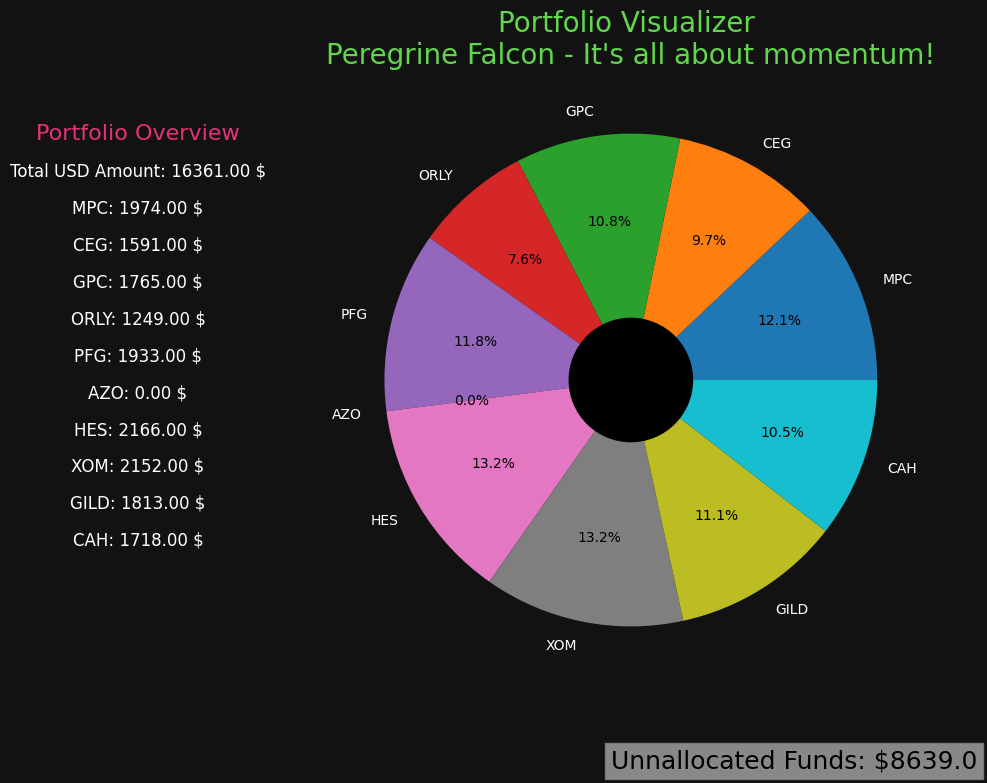

In [32]:
# Plot a pie chart showing the distribution of equity by stock
fig, ax = plt.subplots(figsize=(16,8))

ax.set_facecolor('black')
ax.figure.set_facecolor('#121212')

ax.tick_params(axis='x', color='white')
ax.tick_params(axis='y', color='white')

ax.set_title("Portfolio Visualizer \nPeregrine Falcon - It's all about momentum!", color='#62D74E', fontsize=20)

# patches, texts, autotexts = ax.pie(total_list, labels=df['ticker'], autopct='%1.1f%%', pctdistance=0.65) 
_, texts, _ = ax.pie(total_list, labels=hqm_df['ticker'], autopct='%1.1f%%', pctdistance=0.65) # patches and autotexts not needed, labels=df['ticker'] is important because it's more dynamic
[text.set_color('white') for text in texts] # List comprehension - sets color to white for comfortable UI visualization on a dark background

ins_circle = plt.Circle((0,0), 0.25, color='black') # Creates the black circle in the center of the visual
plt.gca().add_artist(ins_circle) # gca() is used for "get current axis"

ax.text(-2, 1, 'Portfolio Overview', fontsize=16, color = '#E83277', verticalalignment='center', horizontalalignment='center')
ax.text(-2, 0.85, f'Total USD Amount: {sum(values):.2f} $', fontsize=12, color='white', verticalalignment='center', horizontalalignment='center')

counter = 0.15
for ticker in tickers:
    ax.text(-2, 0.85 - counter, f'{ticker}: {values[tickers.index(ticker)]:.2f} $', fontsize=12, color='white', verticalalignment='center', horizontalalignment='center')
    counter+= 0.15 # Add

plt.figtext(0.5, 0.01, f'Unnallocated Funds: ${total_not_invested}', ha="left", 
            fontsize=18, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
plt.show()

In [33]:
# View tickers alphabetically
hqm_df.sort_values('ticker', ascending=True, inplace=True, ignore_index=True)

hqm_df

/var/folders/zm/3chcg6cn3mg3klwn5_22__780000gn/T/ipykernel_13245/4236631669.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hqm_df.sort_values('ticker', ascending=True, inplace=True, ignore_index=True)


,ticker,latest_price,shares,two_year_price_return,two_year_price_return_percentile,one_year_price_return,one_year_price_return_percentile,six_month_price_return,six_month_price_return_percentile,three_month_price_return,three_month_price_return_percentile,hqm_score,buy_price,value
0,AZO,2562.12,0,1.268166,96.023857,0.412274,92.842942,0.262775,93.638171,0.184511,91.451292,93.489066,2035.109985,0.0
1,CAH,78.95,31,0.574318,84.890656,0.717040,97.415507,0.383534,98.210736,0.176502,90.059642,92.644135,55.430000,1718.0
2,CEG,97.16,25,0.849539,92.644135,0.849539,98.60835,0.560477,99.602386,0.203868,94.035785,96.222664,63.650002,1591.0
3,GILD,86.26,28,0.585399,85.685885,0.285939,88.866799,0.370070,98.011928,0.398722,99.403579,92.992048,64.769997,1813.0
4,GPC,186.10,13,0.986137,93.439364,0.442867,94.632207,0.384999,98.409543,0.196611,92.445328,94.73161,135.820007,1765.0
5,HES,144.76,17,1.829621,98.210736,0.928981,99.204771,0.206971,88.667992,0.165295,87.077535,93.290258,127.449997,2166.0
6,MPC,125.20,19,2.185686,99.204771,1.093877,99.602386,0.274139,94.4334,0.207437,94.234592,96.868787,103.910004,1974.0
7,ORLY,855.97,2,0.927253,93.04175,0.346436,91.451292,0.339232,97.017893,0.224932,96.222664,94.4334,624.609985,1249.0
8,PFG,92.47,27,0.918795,92.842942,0.352427,91.650099,0.307277,95.626243,0.217491,95.626243,93.936382,71.599998,1933.0
9,XOM,113.21,22,2.061467,98.807157,0.921650,99.005964,0.192366,87.872763,0.166051,87.276342,93.240557,97.839996,2152.0


In [34]:
# Store stocks in a list again to pass to yahoo finance
stocks = hqm_df['ticker'].to_list()

stocks

['AZO', 'CAH', 'CEG', 'GILD', 'GPC', 'HES', 'MPC', 'ORLY', 'PFG', 'XOM']

In [35]:
# Download historical prices from yahoo finance
yahoo_df = yf.download(stocks, start, end)
yahoo_df = yahoo_df.loc[:,'Close']

yahoo_df.head(3)

[*********************100%***********************]  10 of 10 completed


,AZO,CAH,CEG,GILD,GPC,HES,MPC,ORLY,PFG,XOM
Date,,,,,,,,,,
2022-06-01,2035.109985,55.43,63.650002,64.769997,135.820007,127.449997,103.910004,624.609985,71.599998,97.839996
2022-06-02,2061.300049,54.50,63.750000,63.459999,136.779999,126.250000,104.269997,634.119995,72.190002,97.669998
2022-06-03,2058.040039,53.82,65.169998,63.450001,135.949997,127.889999,105.620003,631.609985,70.879997,99.089996


In [36]:
# Check dataframe as type and verify
type(yahoo_df)

pandas.core.frame.DataFrame

In [37]:
# Store the number of shares to buy as a list to pass to yahoo finance
num_shares = hqm_df['shares'].to_list()

num_shares

[0, 31, 25, 28, 13, 17, 19, 2, 27, 22]

In [38]:
# Create a cumulative returns dataframe from the data output
cltv_rtns_df = yahoo_df
cltv_rtns_df['s5_value'] = yahoo_df.dot(num_shares)

cltv_rtns_df.head()

,AZO,CAH,CEG,GILD,GPC,HES,MPC,ORLY,PFG,XOM,s5_value
Date,,,,,,,,,,,
2022-06-01,2035.109985,55.430000,63.650002,64.769997,135.820007,127.449997,103.910004,624.609985,71.599998,97.839996,16364.639915
2022-06-02,2061.300049,54.500000,63.750000,63.459999,136.779999,126.250000,104.269997,634.119995,72.190002,97.669998,16331.759911
2022-06-03,2058.040039,53.820000,65.169998,63.450001,135.949997,127.889999,105.620003,631.609985,70.879997,99.089996,16379.489784
2022-06-06,2099.060059,53.740002,66.389999,62.029999,139.660004,126.610001,109.389999,637.799988,71.730003,98.839996,16495.680035
2022-06-07,2119.979980,53.910000,66.550003,62.540001,140.809998,129.089996,113.650002,634.840027,72.199997,103.370003,16763.710064


In [39]:
# View output from yahoo finance data download
yahoo_df = yf.download(stocks, start, end)
yahoo_df = yahoo_df.loc[:,'Close']

yahoo_df.head(3)

[*********************100%***********************]  10 of 10 completed


,AZO,CAH,CEG,GILD,GPC,HES,MPC,ORLY,PFG,XOM
Date,,,,,,,,,,
2022-06-01,2035.109985,55.43,63.650002,64.769997,135.820007,127.449997,103.910004,624.609985,71.599998,97.839996
2022-06-02,2061.300049,54.50,63.750000,63.459999,136.779999,126.250000,104.269997,634.119995,72.190002,97.669998
2022-06-03,2058.040039,53.82,65.169998,63.450001,135.949997,127.889999,105.620003,631.609985,70.879997,99.089996


In [40]:
# Not sure why I did this - seems like an extra step - investigate later
cltv_rtns_df = yahoo_df
cltv_rtns_df['s5_value'] = yahoo_df.dot(num_shares)

cltv_rtns_df.head()

,AZO,CAH,CEG,GILD,GPC,HES,MPC,ORLY,PFG,XOM,s5_value
Date,,,,,,,,,,,
2022-06-01,2035.109985,55.430000,63.650002,64.769997,135.820007,127.449997,103.910004,624.609985,71.599998,97.839996,16364.639915
2022-06-02,2061.300049,54.500000,63.750000,63.459999,136.779999,126.250000,104.269997,634.119995,72.190002,97.669998,16331.759911
2022-06-03,2058.040039,53.820000,65.169998,63.450001,135.949997,127.889999,105.620003,631.609985,70.879997,99.089996,16379.489784
2022-06-06,2099.060059,53.740002,66.389999,62.029999,139.660004,126.610001,109.389999,637.799988,71.730003,98.839996,16495.680035
2022-06-07,2119.979980,53.910000,66.550003,62.540001,140.809998,129.089996,113.650002,634.840027,72.199997,103.370003,16763.710064


In [41]:
# Create a cumulative returns dataframe from plot
s5_df = cltv_rtns_df['s5_value'].to_frame()

s5_df.tail(15) 

,s5_value
Date,
2022-11-04,20644.659607
2022-11-07,20859.390205
2022-11-08,20728.160149
2022-11-09,20304.220177
2022-11-10,20763.869881
2022-11-11,20726.889893
2022-11-14,20775.019791
2022-11-15,20825.499916
2022-11-16,20713.709961


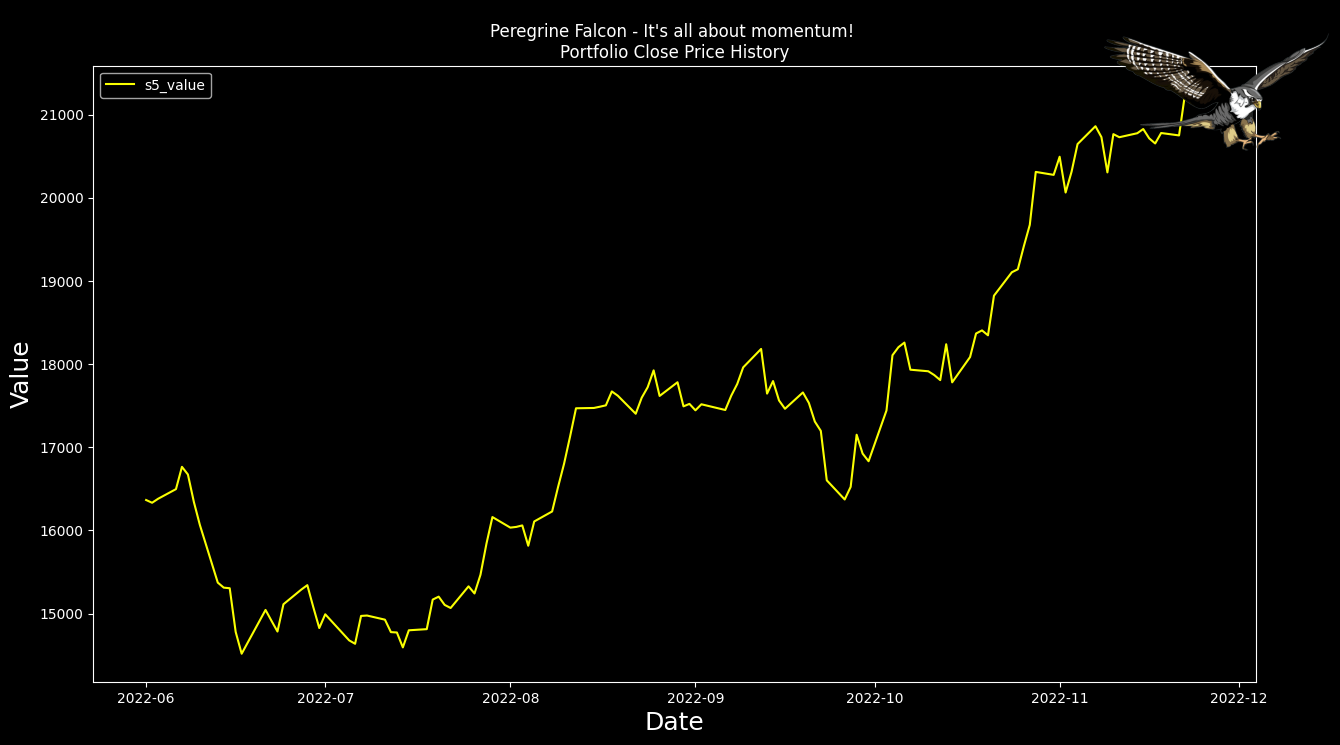

In [43]:
"""    
IMPORTANT - Known Error
Run this code block twice for the dark background to be reflected
"""
# Plot output 
fig, ax = plt.subplots(figsize=(15,8))
for i in s5_df.columns.values :
    ax.plot(s5_df[i], '#FAFF00', label = i)

ax.set_title("Peregrine Falcon - It's all about momentum! \nPortfolio Close Price History")
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Value' , fontsize=18)
ax.legend(s5_df.columns.values , loc = 'upper left')

# Add image
im = plt.imread('falcon.png')
falcon_fig = fig.add_axes([0.75,0.75,0.2,0.2], anchor='NE', zorder=1)
falcon_fig.imshow(im)
falcon_fig.axis('off')

# Style sheet
# plt.style.use('fivethirtyeight')
plt.style.use('dark_background')

# Show plot
plt.show(fig, falcon_fig)
